<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint13/M4_DS_414_Topic_Modeling_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

Apply Topic Modeling to Analyze a corpus of Amazon reviews

- Load in the Amazon Review dataset
- Clean the dataset
- Vectorize the dataset
- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end

In [23]:
!pip install -U pyLDAvis  #==3.3.1

In [24]:
!pip install pandarallel==1.4.8

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Restart runtime!

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

----
### Load the Amazon Review corpus
This dataset is located in the Sprint 1 Module 1 `/data` directory.

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [2]:
# A "brute force" way to get the Amazon reviews dataset; just clone the Sprint 1 repo!
# Overkill, but it does the job!
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git

fatal: destination path 'DS-Unit-4-Sprint-1-NLP' already exists and is not an empty directory.


In [3]:
!unzip '/content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip'

Archive:  /content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
replace Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
data_path = "/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(data_path)

In [5]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


----

### Clean data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer.

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [6]:
df.shape

(28332, 24)

In [7]:
df['reviews.text'][8505]

'Have had zero issues with longevity or voltage. As good as the major brand batteries'

In [8]:
def clean_data(text):
  """
  Cleans data to remove unwanted characters and punctuation.
  """
 # YOUR CODE HERE
 # Remove new line and '\xa0' characters
  text = " ".join(text.split())
 # Remove punctuation
  text = re.sub('[^a-zA-Z$ 0-9]', '', text)
 # Remove any double whitespaces created by cleaning
  text = re.sub("[ ]{2,}", ' ', text)

  return text.lower()

In [9]:
# create a clean_text column by applying  clean_data to your text
df['clean_text'] = df['reviews.text'].apply(clean_data)

In [10]:
alphebetical_chars = ["ABCDEFGHIJKLMNOP"]
# check if any of these alphabetical chars exist in your clean chars
assert df.clean_text.isin(alphebetical_chars).sum() == 0, "Did you case normalize your text inside of your clean_data function?"

------

## Determine number of topics

We are going to run an experiment to determine how many topics exists within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data.

Just as we did in the guided project, we'll be running a gridseach over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use.


In [11]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df.primaryCategories.isin(["Electronics"])

# use mask to select all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [12]:
df_electronics.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,great case to keep everything in its place my ...
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,after discarding and getting rid of broken cd ...
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,a few dollars more but i am boycotting amazon


------
### Tokenize your documents

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example on how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles.



In [13]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_md")

In [ ]:
# Original assignment (SKIPPED here, used solution video code)
# identify how many processors your machine has - save the result to `n_processors`
import os

# Check the number of CPU cores
n_processors = os.cpu_count()
print("Number of CPU cores:", n_processors)

# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# initialize just like we did in the guided project
# YOUR CODE HERE
pandarallel.initialize(progress_bar=True, nb_workers = nb_workers)

Number of CPU cores: 2
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
%%time
# Skipped the list comprehension in the original assignment
# create our tokens in the form of lemmas
# We're using parallel_apply here so we need to run pandarallel first before this cell
# df_electronics['lemmas'] = df_electronics['clean_text'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

# Or if we don't use list comprehension, we will write out the full for loop like this like in solution video:
def tokenizer(text):
  lemmas = []
  for token in nlp(text):
    if (not token.is_stop) and (not token.is_punct) and (not token.is_space):
      lemmas.append(token.lemma_.lower())
  return lemmas

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [15]:
# Initialize pandarallel to use 10 workers
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
%%time
# ~2.5 mins with 10 workers on Colab
# pandarallel and pyLDAvis not agreeing on the Python version to use, so I just skipped using pandarallel and it took 3 mins to run tokenizer
# Create our tokens in the form of lemmas
df_electronics['lemmas'] = df_electronics['clean_text'].apply(tokenizer) # instead of .parallel_apply(tokenizer)

CPU times: user 3min 3s, sys: 684 ms, total: 3min 4s
Wall time: 3min 7s


In [18]:
df_electronics['lemmas'].iloc[0]

['great', 'case', 'place', 'husband', 'love', 'hold', 'lot', 'cd']

### Use the corpora class to prep your data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to.

In [21]:
# Create lemma dictionary using Dictionary - save result to `id2word`
# corpora from gensim
# id2word is a gensim dictionary object for the corpora that maps word IDs to words
id2word = corpora.Dictionary(df_electronics['lemmas'])

# Create Term Document Frequency list - save result to `corpus`
# text is the list of lemmas correspond to a review
corpus = [id2word.doc2bow(text) for text in df_electronics['lemmas']]

# YOUR CODE HERE


id2word is a gensim dictionary object for the corpora that maps words ids to words.

In [22]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [23]:
# The first 8 word IDs correspond to the words in the first review
[id2word[index] for index in range(8)]

['case', 'cd', 'great', 'hold', 'husband', 'lot', 'love', 'place']

In [24]:
# Using id2word's .doc2bow() method, convert our input docs (list of lemmas) to their "bag of words" representation in gensim:
# Return a list of tuples of (word ID, frequency), word 0 only appears 1 time, actually all words appear only once
id2word.doc2bow(df_electronics['lemmas'].iloc[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

In [27]:
# In the 2000th review, Here is a list of tuples with the word ID aka lemma and their frequencies
index = 2000
print(f'corpus[2000] is {corpus[index]} \n')

corpus[2000] is [(6, 1), (40, 1), (58, 1), (65, 1), (109, 1), (118, 1), (120, 1), (133, 3), (151, 1), (159, 1), (168, 1), (190, 1), (195, 3), (241, 1), (256, 1), (291, 1), (439, 1), (479, 1), (727, 1), (1017, 1), (1341, 1), (1402, 1), (1502, 2), (1553, 1), (1582, 1), (1741, 1), (1759, 1), (2314, 1), (2323, 1), (2615, 1), (2784, 1), (2930, 2), (3040, 1), (3245, 1), (3743, 1)] 



## Gridsearch the number of topics

Just as we did in the guided project, we're going to run a `for` loop over a range of possible number of topics and then plot the `coherence_values` to determine which number of topics leads to the most sensible grouping of documents.

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): # limit is up to whatever number topics
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,           # ldamulticore is parallel processing
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=16, step=2)

CPU times: user 3min 36s, sys: 11.6 s, total: 3min 47s
Wall time: 7min 55s


In [29]:
# So we have the number of topics and their coherence values
# number of topics start from 2, 4, 6, 8.... all the way to 14, not 16 because it's not all-inclusive for the start/stop

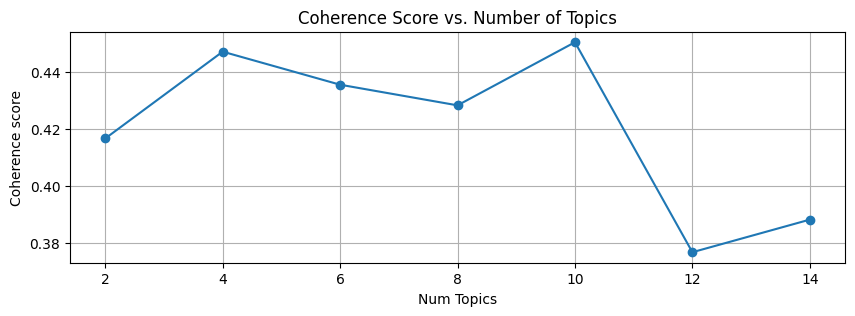

In [30]:
start=2; limit=16;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(10,3))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

For some reason, the solution video has the best coherence score when the number of topics is 6, but in my case it's 10.

In [36]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`

# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`

max_coherence_val_index = np.argmax(coherence_values)
print(f'Model number {max_coherence_val_index} has the highest coherence value.')

lda_trained_model = model_list[max_coherence_val_index] # It's technically 10 topics with the highest score but in this case it's better to use 4 topics

# YOUR CODE HERE

Model number 4 has the highest coherence value.


In [35]:
lda_trained_model

## Use pyLDAvis to visualize your topics

Take a look at the topic bubbles and bar chart for the terms on the right hand side.  

- Describe the topic bubbles.
- Do they overlap or not?
- What does it mean when they overlap?
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [31]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


In [37]:
# Topics are defined by weighted probabilities of word occurrences in a doc
lda_trained_model.show_topics()

[(0,
  '0.062*"not" + 0.022*"case" + 0.020*"buy" + 0.019*"like" + 0.018*"come" + 0.015*"time" + 0.014*"screen" + 0.014*"work" + 0.013*"m" + 0.012*"thing"'),
 (1,
  '0.081*"old" + 0.075*"kindle" + 0.065*"year" + 0.052*"fire" + 0.051*"love" + 0.038*"buy" + 0.031*"tablet" + 0.025*"new" + 0.024*"8" + 0.020*"2"'),
 (2,
  '0.148*"love" + 0.082*"buy" + 0.062*"gift" + 0.048*"christmas" + 0.038*"daughter" + 0.037*"use" + 0.031*"great" + 0.029*"purchase" + 0.024*"easy" + 0.024*"get"'),
 (3,
  '0.087*"kid" + 0.080*"tablet" + 0.048*"great" + 0.042*"use" + 0.041*"love" + 0.035*"watch" + 0.030*"easy" + 0.027*"child" + 0.024*"app" + 0.020*"time"'),
 (4,
  '0.072*"game" + 0.041*"read" + 0.037*"hd" + 0.033*"play" + 0.029*"great" + 0.028*"perfect" + 0.028*"book" + 0.025*"use" + 0.024*"size" + 0.022*"user"'),
 (5,
  '0.086*"ipad" + 0.045*"battery" + 0.041*"life" + 0.030*"$" + 0.021*"load" + 0.021*"reading" + 0.021*"great" + 0.019*"low" + 0.016*"cost" + 0.016*"expensive"'),
 (6,
  '0.107*"tablet" + 0.083*

In [38]:
# plot your topics here -- using pyLDAvis
# YOUR CODE HERE
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_trained_model,
                                     corpus=corpus,
                                     dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.086305 -0.125699       1        1  15.726462
6     -0.141806 -0.066841       2        1  15.535075
0     -0.004459  0.050550       3        1  13.676065
1     -0.177312  0.192764       4        1  12.826268
3     -0.179313 -0.026422       5        1  11.668080
4      0.047735 -0.257383       6        1   7.915045
2     -0.132244  0.138004       7        1   7.914751
9      0.162854 -0.153077       8        1   6.603518
5      0.249026  0.012008       9        1   6.001211
7      0.261824  0.236096      10        1   2.133525, topic_info=          Term         Freq        Total Category  logprob  loglift
6         love  4527.000000  4527.000000  Default  30.0000  30.0000
719     tablet  6797.000000  6797.000000  Default  29.0000  29.0000
1404       kid  1999.000000  1999.000000  Default  28.0000  28.0000
151        old  2049.000000  2049.000000  Default  27.0000  27.0000
117      price  2052.000000  2052.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
33         one    66.559591   128.073139  Topic10  -4.1417   3.1929
234   purchase   188.203906  1680.219988  Topic10  -3.1023   1.6582
731        far    87.172193   525.586010  Topic10  -3.8719   2.0508
764       help    51.602791   270.498771  Topic10  -4.3962   2.1907
105       mean    26.369311    47.194316  Topic10  -5.0676   3.2653

[554 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1446      1  0.195253        $
1446      5  0.032908        $
1446      9  0.770043        $
56        3  0.158503       10
56        4  0.836242       10
...     ...       ...      ...
1061      4  0.999500     year
1414      3  0.994286    young
1576      3  0.077145  youtube
1576      5  0.919311  youtube
1553      4  0.994407       yr

[730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 1, 2, 4, 5, 3, 10, 6, 8])

## Create a Topic id/name dictionary

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool.

We'll use a function to map the the viz tool index ordering with the train LDA model ordering.

In [39]:
# create a dictionary
# keys - use topic ids from pyLDAvis visualization
# values - topic names that you create
# save dictionary to `vis_topic_name_dict`

# THE HUMAN TOUCH BY ASSIGNING TOPIC NAMES TO TOPIC INDICES
vis_topic_name_dict = {1: 'Kindle Fire',
                       2: 'Tablet',
                       3: 'Troubleshoot',
                       4: 'Warranty',
                       5: 'For Entertainment',
                       6: 'For Travel',
                       7: 'As a Gift',
                       8: 'Portability',
                       9: 'For Learning',
                       10: 'Sentiments'}
# YOUR CODE HERE


The topic index and names have been for the pyLDAvis tool. But now we need to transfer all our info onto the gensim LDA model. We need a dictionary to map the indices from pyLDAvis to indices on gensim LDA.

### Re-assign index to gensim LDA

In [40]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic IDs bewteen the trained LDA model
    and the viz tool are different. So we need to create a look up dictionary that maps
    the correct association between topic IDs from both sources.
    """
    # value is order of topic IDs accoridng to pyLDAvis tool
    # key is order of topic IDs according to gensim LDA model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # Invert dictionary so that:
    # key is order of topic IDs accoridng to pyLDAvis tool
    # value is order of topic IDs according to gensim LDA model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}

    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [44]:
vis.topic_coordinates

,x,y,topics,cluster,Freq
topic,,,,,
8,-0.086305,-0.125699,1,1,15.726462
6,-0.141806,-0.066841,2,1,15.535075
0,-0.004459,0.050550,3,1,13.676065
1,-0.177312,0.192764,4,1,12.826268
3,-0.179313,-0.026422,5,1,11.668080
4,0.047735,-0.257383,6,1,7.915045
2,-0.132244,0.138004,7,1,7.914751
9,0.162854,-0.153077,8,1,6.603518
5,0.249026,0.012008,9,1,6.001211


Create a topic id/name look up dict
that is aligned with the index ordering of the trained gensim LDA model

In [41]:
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [42]:
topic_name_dict

{8: 'Kindle Fire',
 6: 'Tablet',
 0: 'Troubleshoot',
 1: 'Warranty',
 3: 'For Entertainment',
 4: 'For Travel',
 2: 'As a Gift',
 9: 'Portability',
 5: 'For Learning',
 7: 'Sentiments'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name.

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output.

In [43]:
def get_topic_ids_for_docs(lda_model, corpus):

    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document.

    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model

    corpus: nested lists of tuples,
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]

    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus
    """

    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus: # the bag of words vectors for each review

        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)

        # iterate through the topic id/prob pairs
        for topic_id_prob in topic_id_prob_tuples:

            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get the index for the topic that had the highest probability, for the current document
        max_topic_prob_ind = np.argmax(topic_probs)
        # get the corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store the most probable topic id for the current document
        doc_topic_ids.append(max_prob_topic_id)

    return doc_topic_ids

In [45]:
# use get_topic_ids_for_docs to get the topic id for each doc in the corpus - save result to `doc_topic_ids`
doc_topic_ids = get_topic_ids_for_docs(lda_model=lda_trained_model, corpus=corpus)

# create a new feature in df_electronics called topic_id using `doc_topic_ids`
df_electronics['topic_id'] = doc_topic_ids

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`
# topic_name_dict[topic_id] is the human-generated names, so we apply the map to the topic_id column to get the names
df_electronics['new_topic_name'] = df_electronics['topic_id'].apply(lambda topic_id: topic_name_dict[topic_id])

# YOUR CODE HERE

## Congratulations! You have created new topic names for your documents.

In [46]:
cols = ["reviews.text", "new_topic_name", "topic_id"]
df_electronics[cols].head(15)

,reviews.text,new_topic_name,topic_id
8343,Great case to keep everything in its place! My...,As a Gift,2
8344,After discarding and getting rid of broken cd ...,Troubleshoot,0
8345,"A few dollars more, but I am boycotting amazon",Troubleshoot,0
8346,My initial impression of this was very good. T...,Portability,9
8347,Pros: Standard Echo. Cons: Older generation Ec...,Kindle Fire,8
8348,"Pros: Got it for under 50, much impressive sou...",Kindle Fire,8
8349,Pros: I love the Alexa series so when this one...,Tablet,6
8350,"ASIDE FROM THE FACT THAT THE SCREEN IS SMALL, ...",Tablet,6
8351,"I wasn't sure I even wanted this item, but cau...",Troubleshoot,0
8352,Pros: Works good like Alexia Cons: setting it ...,Tablet,6


-----
# Stretch Goals -- see if you can create a model to classify the reviews into the latent topics you've discovered!


- Treat `topic_id` as the `y` (target) vector and train a supervised learning model to predict the topic of each document
- Report your results on the Slack channel!

## Topic Modeling References



- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures